# Exoplanet transit

In this tutorial we will reduce raw images to produce a transit light curve of WAPS-12 b. All images can be downloaded from [https://astrodennis.com/](https://astrodennis.com/).

## Managing the FITS

For this observation, the headers of the calibration images do not contain information about the nature of each image, bias, dark or flat. We will then retrieve our images by hand (where usually we would employ a [FitsManager](prose.FitsManager) object) 

In [1]:
from glob import glob

darks = glob("/Users/lgrcia/data/WASP12-astrodennis/Darks/*.fit")
bias = glob("/Users/lgrcia/data/WASP12-astrodennis/Bias/*.fit")
flats = glob("/Users/lgrcia/data/WASP12-astrodennis/Flats/*.fit")
sciences = sorted(glob("/Users/lgrcia/data/WASP12-astrodennis/ScienceImages/*.fit"))

## The full reduction

What follows is the full reduction sequences, including the selection of a reference image to align sources and scale apertures on. More details are provided in the basic [Photometry](./photometry.ipynb) tutorial

In [2]:
import numpy as np
from prose import FITSImage, Sequence, blocks

# reference is middle image
ref = FITSImage(sciences[len(sciences) // 2])

calibration = Sequence(
    [
        blocks.Calibration(darks=darks, bias=bias, flats=flats),
        blocks.Trim(),
        blocks.PointSourceDetection(n=40),  # stars detection
        blocks.Cutouts(21),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.psf.Moffat2D(),  # modeling EPSF
    ]
)

calibration.run(ref, show_progress=False)

photometry = Sequence(
    [
        calibration[0],  # calibration block (same as above)
        blocks.PointSourceDetection(n=12, minor_length=8),  # fewer stars detection
        blocks.Cutouts(21),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
        blocks.ComputeTransformTwirl(ref),  # compute alignment
        blocks.AlignReferenceSources(ref),  # alignment
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # annulus background
        blocks.GetFluxes(
            "fwhm",
            airmass=lambda im: im.header["AIRMASS"],
            dx=lambda im: im.transform.translation[0],
            dy=lambda im: im.transform.translation[1],
        ),
    ]
)

photometry.run(sciences)

  0%|          | 0/336 [00:00<?, ?images/s]

We can check the total processing time of each block with

In [3]:
photometry


╒═════════╤════════╤═══════════════════════╤════════════════╕
│   index │ name   │ type                  │ processing     │
╞═════════╪════════╪═══════════════════════╪════════════════╡
│       0 │        │ Calibration           │ 1.951 s (4%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       1 │        │ PointSourceDetection  │ 19.651 s (40%) │
├─────────┼────────┼───────────────────────┼────────────────┤
│       2 │        │ Cutouts               │ 2.216 s (5%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       3 │        │ MedianEPSF            │ 0.178 s (0%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       4 │        │ Gaussian2D            │ 3.153 s (6%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       5 │        │ ComputeTransformTwirl │ 0.550 s (1%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       6 │        │ AlignReferenceSources │ 0.140 s (0%)   │
├───────

## Differential photometry

Now that the photometry has been extracted, let's focus on our target and produce a differential light curve for it.

All fluxes have been saved in the [GetFluxes](prose.blocks.GetFluxes) block, in a [Fluxes](prose.Fluxes) object 

In [4]:
from prose import Fluxes

fluxes: Fluxes = photometry[-1].fluxes


We can check the reference image, on which all images sources have been aligned, and pick our target

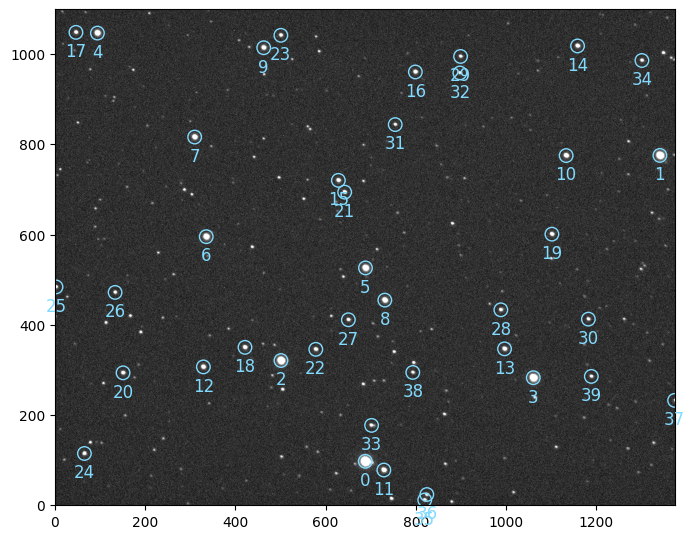

In [5]:
ref.show()

set this target (source `6`) in the [Fluxes](prose.Fluxes) object and proceed with automatic differential photometry

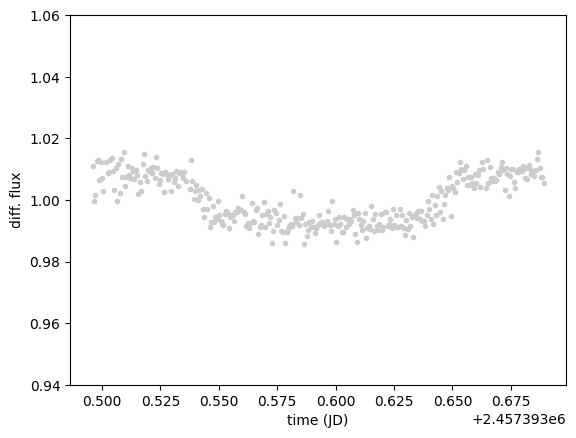

In [6]:
import matplotlib.pyplot as plt

fluxes.target = 6
# good practice
fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3)
diff = fluxes.autodiff()

# plotting
ax = plt.subplot(xlabel="time (JD)", ylabel="diff. flux", ylim=(0.94, 1.06))
diff.plot()

And here is our planetary transit. To validate the differential photometry and the automatic choice of comparison stars, we can plot their light curves along the target light curve

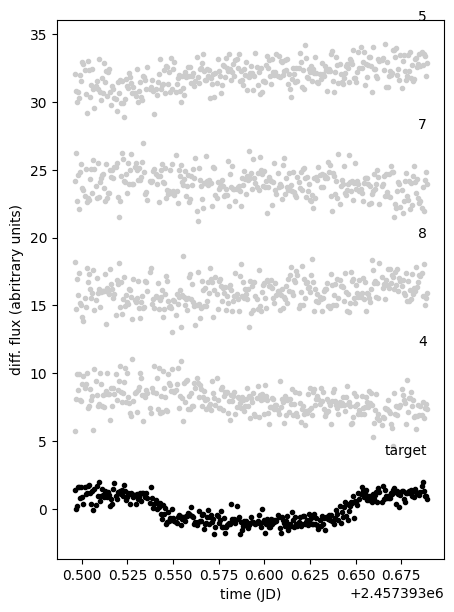

In [12]:
plt.figure(None, (5, 7))
ax = plt.subplot(xlabel="time (JD)", ylabel="diff. flux (abritrary units)")


# plotting only the first five comparisons
for j, i in enumerate([diff.target, *diff.comparisons[0:5]]):
    y = diff.fluxes[diff.aperture, i].copy()
    y = (y - np.mean(y)) / np.std(y) + 8 * j
    plt.text(
        diff.time.max(), np.mean(y) + 4, i if i != diff.target else "target", ha="right"
    )
    plt.plot(diff.time, y, ".", c="0.8" if i != diff.target else "k")

# Explanatory measurements

To help modeling the light curve, some explanatory measurements have been stored in

In [8]:
diff.dataframe

bkg   airmass        dx        dy      fwhm          time  \
0    261.908217  1.878414 -0.314490  0.566460  4.823861  2.457393e+06   
1    263.309778  1.870291 -1.088033  0.466066  4.473168  2.457393e+06   
2    261.167119  1.862163 -0.868474  0.423316  4.369253  2.457393e+06   
3    252.933837  1.854302 -0.953985  0.551378  4.677914  2.457393e+06   
4    252.841623  1.846374 -1.025708  0.448884  4.735902  2.457393e+06   
..          ...       ...       ...       ...       ...           ...   
327  157.205167  1.013443  1.007175  0.613441  4.130921  2.457394e+06   
328  157.248958  1.013356  1.577194  0.623359  4.012928  2.457394e+06   
329  156.650647  1.013278  0.737424  0.519273  4.491135  2.457394e+06   
330  156.423297  1.013210  0.700936  0.711975  4.576204  2.457394e+06   
331  157.131704  1.013150  0.977755  0.784270  4.015622  2.457394e+06   

         flux  
0    1.011125  
1    0.999756  
2    1.001618  
3    1.012742  
4    1.012824  
..        ...  
327  1.015685  
328  1.010365  
329  1.007430  
330  1.007304  
331  1.005600  

[332 rows x 7 columns]

that we can plot to check for any correlation with the differential flux

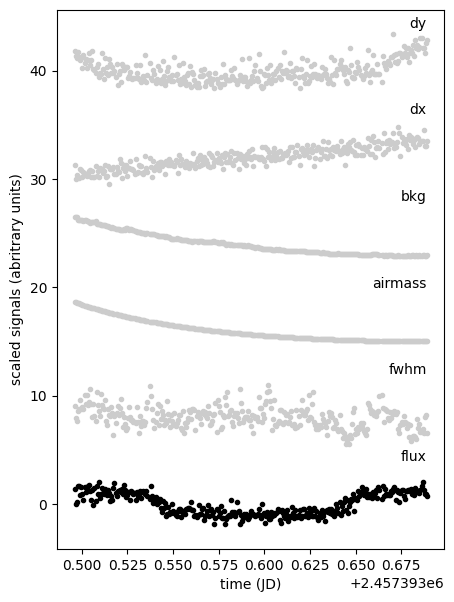

In [14]:
plt.figure(None, (5, 7))
ax = plt.subplot(xlabel="time (JD)", ylabel="scaled signals (abritrary units)")

for i, name in enumerate(["flux", "fwhm", "airmass", "bkg", "dx", "dy"]):
    y = diff.df[name].copy()
    y = (y - np.mean(y)) / np.std(y) + 8 * i
    plt.text(diff.time.max(), np.mean(y) + 4, name, ha="right")
    plt.plot(diff.time, y, ".", c="0.8" if name != "flux" else "k")


## Multiprocessing alternative

For those in a hurry, the photometry sequence can be made parallel

In [10]:
from prose.core.sequence import SequenceParallel

faster_photometry = SequenceParallel(
    [
        blocks.Calibration(darks=darks, bias=bias, flats=flats, shared=True),
        blocks.PointSourceDetection(
            n=12, minor_length=8
        ),  # stars detection for alignment
        blocks.Cutouts(21),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
        blocks.ComputeTransformTwirl(ref),  # compute alignment
        blocks.AlignReferenceSources(ref),  # align sources
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # annulus background
    ],
    [
        blocks.GetFluxes(
            "fwhm",
            airmass=lambda im: im.header["AIRMASS"],
            dx=lambda im: im.transform.translation[0],
            dy=lambda im: im.transform.translation[1],
        ),
    ],
)

faster_photometry.run(sciences)

  0%|          | 0/336 [00:00<?, ?images/s]

The [SequenceParallel](prose.core.sequence.SequenceParallel) class is a subclass of [Sequence](prose.core.sequence.Sequence) that allows to run blocks in parallel. This object takes two lists of blocks. The first sequence of blocks is run for each image on a different CPU core, the second is run sequentially and must contain all blocks that retain data and are slower to move between CPU cores.